# Song genre prediction
<b>Predict a song genre using its track information and features</b>

For this project, my research question is: <b>Can we predict a track genre based on track info and features?</b><br>
<br>
Through its API, Spotify provided users with variety of track features, from tempo and key to whether the song is with lyrics or not and whether the song is suitable for dancing or not. These track features will be the X variables. Using these track features, I will predict the genre of the song. This also means, that genre is the Y variable.<br>
<br>
The unit of observation of this project is song. I will use 6 Spotify playlists from 6 different era: All Out 50s, All Out 60s, All Out 70s, All Out 80s, All Out 90s, and All Out 00s. Each playlist consist of minimum 100 songs.<br>
<br>
For this proejctI will use <a href="https://github.com/plamere/spotipy">Spotipy</a> library to get data from Spotify API. Let's get started!

## Data processing

In this section, I will firstly get the track IDs from all the playlist. Then, I from each track ID, will get the track features. From the Artist data, I will then get the possible genre of the song. Why possible genre? Because in Spotify, the genre is related to the artist, not the song. Therefore, each song might be tagged with multiple genre. These list of genre that is a categorical variables then will be transformed into dummy variables.
<hr>

Import necessary libraries for this project, then connect with my Spotify for Developer credentials

In [1]:
from __future__ import print_function
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from pprint import pprint
import json
import csv
import time
import sys
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn as sk

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id='eaa563769e874ccd85c8185f682ef625', client_secret='9d60c77a99e34791a1b126a06d43dcf6'))

Next, define the playlist IDs I'm going to work with. Since I hand-picked the playlist through Spotify Web Player, I was able to get the playlist ID through Spotify Web Player. Another way of doing this is to get a list of a user's playlist and search for the playlist IDs.<br>
<br>
In the below array, the playlist are sorted by oldest to newest (50s to 00s)

In [2]:
playlists = ['37i9dQZF1DWSV3Tk4GO2fq', '37i9dQZF1DXaKIA8E7WcJj', '37i9dQZF1DWTJ7xPn4vNaz', '37i9dQZF1DX4UtSsGT1Sbe', '37i9dQZF1DXbTxeAdrVG2l', '37i9dQZF1DX4o1oenSJRJd']

In the below code, we're getting the track IDs of every song on the above playlists and save them in a csv file, so that we can work with the data locally in the next process.

In [3]:
#source this
get_tracks = []

for list in playlists:
    offset = 0    
    
    while True:
        response = sp.playlist_items(list,
                                     offset=offset,
                                     fields='items.track.id,total',
                                     additional_types=['track'])

        if len(response['items']) == 0:
            break
        
        get_tracks.extend(response['items'])
        offset = offset + len(response['items'])
        

with open("tracks.json", "w") as outfile:
    json.dump(get_tracks, outfile)

In the below code, we take the tracks data stored locally and continue work with it. The data was saved as json file, we're going to transform it into a dataframe (df) for further working on it.

In [4]:
import pandas as pd

data = pd.read_json("tracks.json")
df = pd.json_normalize(data['track'])
df.head()

,id
0,06PdA0DLgF4BfAeUNZAbFG
1,40KCF1U2DNceYsugxZQruU
2,2viNxee3uNcVXrXvwAUVir
3,72nqbbrKjhXmDdRXQGq115
4,50RwvvEKX5Q7AZt8FTAwIF


In the next step, we take the track names, artist names and artist ids from the track id data we have.

In [5]:
#source this
tracks = df['id']
track_names = []
track_artists_name = []
track_artists_id = []

for track in tracks:
    urn = 'spotify:track:' + track
    track = sp.track(urn)
    track_name = track['name']
    track_artist_name = track['artists'][0]['name']
    track_artist_id = track['artists'][0]['id']
    track_explicit = track['explicit']
    track_album_type = track['album']['album_type']
    track_names.append(track_name)
    track_artists_name.append(track_artist_name)
    track_artists_id.append(track_artist_id)
    
df['track names'] = track_names
df['artists name'] = track_artists_name
df['artists id'] = track_artists_id

df.head()

,id,track names,artists name,artists id
0,06PdA0DLgF4BfAeUNZAbFG,Blueberry Hill,Fats Domino,09C0xjtosNAIXP36wTnWxd
1,40KCF1U2DNceYsugxZQruU,Broken Hearted Melody,Sarah Vaughan,1bgyxtWjZwA5PQlDsvs9b8
2,2viNxee3uNcVXrXvwAUVir,That's Amore,Dean Martin,49e4v89VmlDcFCMyDv9wQ9
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs
4,50RwvvEKX5Q7AZt8FTAwIF,That'll Be The Day,Buddy Holly,3wYyutjgII8LJVVOLrGI0D


Next:<br>
From each track ID, will get the track features consisting of the following (Web API Reference | Spotify for Developers, n.d.):
<ul>
    <li><b>Accousticness</b> (A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.)</li>
    <li><b>Danceability</b> (Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.)</li>
    <li><b>Duration_ms</b> (The duration of the track in milliseconds.)</li>
    <li><b>Energy</b> (Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.)</li>
    <li><b>Instrumentalness</b> (Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.)</li>
    <li><b>Key</b> (The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.)</li>
    <li><b>Liveness</b> (Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.)</li>
    <li><b>Loudness</b> (The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.)</li>
    <li><b>Mode</b> (Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.)</li>
    <li><b>Speechiness</b> (Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.)</li>
    <li><b>Time signature</b> (An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).)</li>
    <li><b>Valence</b> (A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).)</li>
</ul>

In [6]:
#source this
track_ids = df['id']
track_acousticness = []
track_danceability = []
track_duration_ms = []
track_energy = []
track_instrumentalness = []
track_key = []
track_liveness = []
track_loudness = []
track_mode = []
track_speechiness = []
track_time_signature = []
track_valence = []
                                            
for id in track_ids:
    features = sp.audio_features(id)
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    duration_ms = features[0]['duration_ms']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    key = features[0]['key']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    mode = features[0]['mode']
    speechiness = features[0]['speechiness']
    time_signature = features[0]['time_signature']
    valence = features[0]['valence']
    
    track_acousticness.append(acousticness)
    track_danceability.append(danceability)
    track_duration_ms.append(duration_ms)
    track_energy.append(energy)
    track_instrumentalness.append(instrumentalness)
    track_key.append(key)
    track_liveness.append(liveness)
    track_loudness.append(loudness)
    track_mode.append(mode)
    track_speechiness.append(speechiness)
    track_time_signature.append(time_signature)
    track_valence.append(valence)
    
df['track acousticness'] = track_acousticness
df['track danceability'] = track_danceability
df['track duration_ms'] = track_duration_ms
df['track energy'] = track_energy
df['track instrumentalness'] = track_instrumentalness
df['track key'] = track_key
df['track liveness'] = track_liveness
df['track loudness'] = track_loudness
df['track mode'] = track_mode
df['track speechiness'] = track_speechiness
df['track time_signature'] = track_time_signature
df['track valence'] = track_valence

df.head()

,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence
0,06PdA0DLgF4BfAeUNZAbFG,Blueberry Hill,Fats Domino,09C0xjtosNAIXP36wTnWxd,0.740,0.489,147880,0.499,0.000236,11,0.1560,-9.702,1,0.0271,3,0.829
1,40KCF1U2DNceYsugxZQruU,Broken Hearted Melody,Sarah Vaughan,1bgyxtWjZwA5PQlDsvs9b8,0.744,0.448,143267,0.500,0.000000,7,0.1910,-11.304,1,0.0356,4,0.768
2,2viNxee3uNcVXrXvwAUVir,That's Amore,Dean Martin,49e4v89VmlDcFCMyDv9wQ9,0.741,0.476,186267,0.226,0.000000,10,0.0944,-10.546,1,0.0295,4,0.500
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.783,0.542,141240,0.347,0.000000,4,0.1440,-14.011,1,0.0268,4,0.596
4,50RwvvEKX5Q7AZt8FTAwIF,That'll Be The Day,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.467,0.536,150133,0.637,0.000000,2,0.0838,-7.774,1,0.0343,4,0.798


In the last step of gathering the data for this project, we'll get the genres from artist ids. The result might return a few genres per artist, therefore for this project, we use only the last genre with the assumption that it's the broadest genre. Then, we save them as a csv file to keep the data locally.

In [7]:
#source this
artists_id = df['artists id']
genres = []

for artist in artists_id:
    urn = 'spotify:artist:' + artist
    artist = sp.artist(urn)
    artist_genres = artist['genres']
    
    if len(artist_genres) != 0:
        broad_genre = artist_genres[-1] #only the last genre with the assumption that it's the broadest genre, also otherwise too many genre present.
    else:
        broad_genre = 'no genre'
    
    genres.append(broad_genre)
    
df['genres'] = genres
df.to_csv('raw_data.csv', index=False)

In the next step, we are working with the local dataset and continue with filtering all the genres to only show the ones containing pop and rock.

In [8]:
df1 = pd.read_csv('raw_data.csv')  
df2 = df1[df1['genres'].str.contains('pop|rock')]
df2['genres'].value_counts()

soft rock              151
rockabilly              56
rock                    50
pop rock                41
yacht rock              41
pop                     28
post-teen pop           25
rock-and-roll           20
sunshine pop            18
synthpop                12
europop                 12
swedish pop             12
symphonic rock          10
dance pop                8
pop rap                  8
viral pop                5
sophisti-pop             5
new wave pop             4
swamp rock               4
pop dance                4
scottish rock            4
country rock             2
roots rock               2
classic garage rock      1
australian rock          1
swamp pop                1
britpop                  1
glam rock                1
power pop                1
latin pop                1
folk rock                1
nz pop                   1
classic uk pop           1
Name: genres, dtype: int64

To make it easier for us to process the genre later on, we're going to transform the values of genres column to the following: when it is a sub genre of pop, we're turning it into 'pop' and when it is a sub genre of rock, we're turning it into 'rock'. The values will be put to a new column named genres-transformed.

In [9]:
df2.loc[df2['genres'].str.contains('pop'), 'genres-transformed'] = 'pop'
df2.loc[df2['genres'].str.contains('rock'), 'genres-transformed'] = 'rock'
df2.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,genres,genres-transformed
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.783,0.542,141240,0.347,0.000000,4,0.1440,-14.011,1,0.0268,4,0.596,sunshine pop,pop
4,50RwvvEKX5Q7AZt8FTAwIF,That'll Be The Day,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.467,0.536,150133,0.637,0.000000,2,0.0838,-7.774,1,0.0343,4,0.798,rockabilly,rock
7,5ueyLj6e6oVaTY0KQ6yLaA,All Shook Up,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,0.881,0.624,117080,0.468,0.000006,10,0.1440,-12.162,1,0.1320,4,0.952,rockabilly,rock
8,2FkCjtQ1lYsf71s2FAS8hE,The Great Pretender,The Platters,6KWcxMWVNVIYbdOQyJtsSy,0.943,0.425,160667,0.401,0.000003,7,0.0720,-9.427,1,0.0315,3,0.531,rockabilly,rock
10,7ljPNANyoIDc7sL0PWaJlu,True Love Ways,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.800,0.221,168707,0.124,0.103000,10,0.3160,-19.545,1,0.0346,4,0.276,rockabilly,rock


We're making dummies out of the genres-transformed values to later on see if there are strong correlation values to each genre.

In [10]:
dummies = df2['genres-transformed'].str.get_dummies()
df2 = pd.concat([df2, dummies], axis=1) 
df2.head()

,id,track names,artists name,artists id,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,genres,genres-transformed,pop,rock
3,72nqbbrKjhXmDdRXQGq115,All I Have to Do Is Dream,The Everly Brothers,4ACplpEqD6JIVgKrafauzs,0.783,0.542,141240,0.347,0.000000,4,0.1440,-14.011,1,0.0268,4,0.596,sunshine pop,pop,1,0
4,50RwvvEKX5Q7AZt8FTAwIF,That'll Be The Day,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.467,0.536,150133,0.637,0.000000,2,0.0838,-7.774,1,0.0343,4,0.798,rockabilly,rock,0,1
7,5ueyLj6e6oVaTY0KQ6yLaA,All Shook Up,Elvis Presley,43ZHCT0cAZBISjO8DG9PnE,0.881,0.624,117080,0.468,0.000006,10,0.1440,-12.162,1,0.1320,4,0.952,rockabilly,rock,0,1
8,2FkCjtQ1lYsf71s2FAS8hE,The Great Pretender,The Platters,6KWcxMWVNVIYbdOQyJtsSy,0.943,0.425,160667,0.401,0.000003,7,0.0720,-9.427,1,0.0315,3,0.531,rockabilly,rock,0,1
10,7ljPNANyoIDc7sL0PWaJlu,True Love Ways,Buddy Holly,3wYyutjgII8LJVVOLrGI0D,0.800,0.221,168707,0.124,0.103000,10,0.3160,-19.545,1,0.0346,4,0.276,rockabilly,rock,0,1


Our dataframe is ready to be processed!

## Feature engineering

For the above dataset, not a lot of transformation happens to the data. We did have to undergo a few steps to actually get the genre: Track id > artist id > genre, while the track feature is relatively easy: Track id > Feature track. We transformed all the pop and rock sub genres into just 2 genres: pop and rock to be used for the prediction.
<hr>

## Descriptive analysis

Now, we're going to look at most strongly correlating variables, possibly also to the genres.

In [11]:
corr = df2.corr()
corr

,track acousticness,track danceability,track duration_ms,track energy,track instrumentalness,track key,track liveness,track loudness,track mode,track speechiness,track time_signature,track valence,pop,rock
track acousticness,1.000000,-0.325963,-0.316790,-0.549173,0.039999,0.035869,0.041445,-0.378793,0.158691,-0.044606,-0.185844,-0.199465,-0.220072,0.220072
track danceability,-0.325963,1.000000,0.021089,0.292094,-0.032120,-0.046570,-0.110286,0.215987,-0.150075,0.134992,0.144364,0.486835,0.212921,-0.212921
track duration_ms,-0.316790,0.021089,1.000000,0.055000,0.015144,-0.046925,-0.069742,0.013321,-0.022688,-0.165117,-0.021977,-0.260616,0.007155,-0.007155
track energy,-0.549173,0.292094,0.055000,1.000000,-0.051124,-0.082386,0.162317,0.760627,-0.105331,0.233373,0.198085,0.442644,0.233613,-0.233613
track instrumentalness,0.039999,-0.032120,0.015144,-0.051124,1.000000,0.101629,0.059800,-0.127103,-0.068596,-0.013902,0.031890,-0.024010,-0.053833,0.053833
track key,0.035869,-0.046570,-0.046925,-0.082386,0.101629,1.000000,-0.054596,-0.091884,-0.133738,0.076995,0.009970,-0.086439,0.022966,-0.022966
track liveness,0.041445,-0.110286,-0.069742,0.162317,0.059800,-0.054596,1.000000,0.147987,0.013749,0.067814,-0.039646,0.052834,0.079953,-0.079953
track loudness,-0.378793,0.215987,0.013321,0.760627,-0.127103,-0.091884,0.147987,1.000000,-0.092289,0.196601,0.113795,0.146077,0.299494,-0.299494
track mode,0.158691,-0.150075,-0.022688,-0.105331,-0.068596,-0.133738,0.013749,-0.092289,1.000000,-0.115032,-0.047155,-0.106192,-0.147524,0.147524
track speechiness,-0.044606,0.134992,-0.165117,0.233373,-0.013902,0.076995,0.067814,0.196601,-0.115032,1.000000,0.047243,0.188793,0.119881,-0.119881


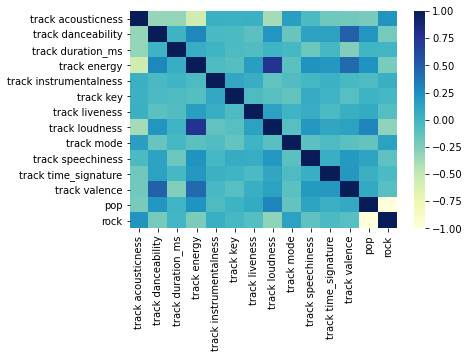

In [12]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="YlGnBu")
plt.show()

From the above correlation table and heatmap, there is no variable that is strongly correlated to the pop and rock genre. Let's now take a look at the track features correlation. We can see that the correlation between track energy and track loudness are highest at 0.76. Let's analyze these in the below graphs!

Text(0.5, 1.0, 'Track Energy per Genres')

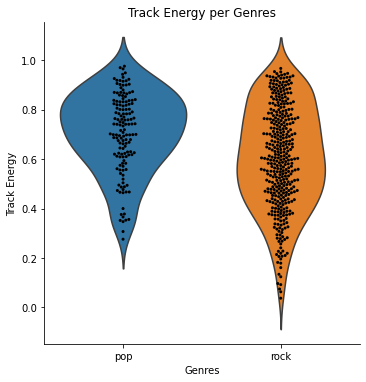

In [13]:
g = sns.catplot(x="genres-transformed", y="track energy", kind="violin", inner=None, data=df2)
sns.swarmplot(x="genres-transformed", y="track energy", color="k", size=3, data=df2, ax=g.ax)
plt.xlabel('Genres') 
plt.ylabel('Track Energy')
plt.title('Track Energy per Genres')

In the graph above, we can see that pop track energy is more grouped in 0.6 to 0.8 while track energy for pop is relatively more spread out from 0.4 to 0.9.

Text(0.5, 1.0, 'Track Loudness per Genres')

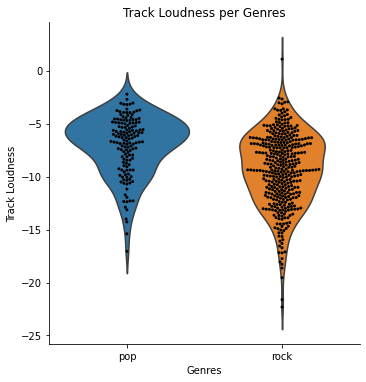

In [14]:
g = sns.catplot(x="genres-transformed", y="track loudness", kind="violin", inner=None, data=df2)
sns.swarmplot(x="genres-transformed", y="track loudness", color="k", size=3, data=df2, ax=g.ax)
plt.xlabel('Genres') 
plt.ylabel('Track Loudness')
plt.title('Track Loudness per Genres')

In the above graph, we can see that pop track loudness is once again more grouped in around -5 while track loudness for rock is more spread out in range, from almost -25decibel to more than 0 decibel. The track loudness for rock is also a bit more even, grouped around -15 until around -6.<br>
<br>
From the above two graphs we can see that pop music are generally higher in the energy and loudness. Rock music energy and loudness are relatively more spread oud in comparison to pop music.

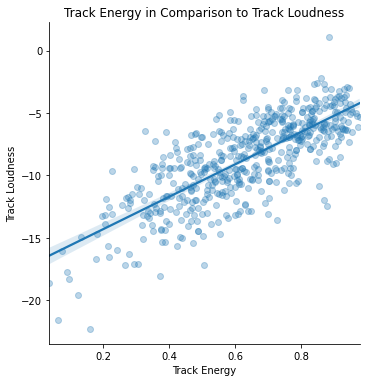

In [15]:
sns.lmplot(x='track energy', y='track loudness', fit_reg=True, data=df2, scatter_kws={'alpha':0.3})
plt.xlabel('Track Energy') 
plt.ylabel('Track Loudness')
plt.title('Track Energy in Comparison to Track Loudness')
plt.show()

The above graph shows the track energy on the x axis and track loudness on the y axis. In this graph, we can analyze better the relationship between the two variables. The track energy that are low or from 0 to 0.4 have their track loudness until around -15 decibels. The track energy that are higher or more than 0.5, have their track loudness ranged from -15 to -2 decibels. The graph shows relatively linear distribution of dots, meaning that the track energy have linear relation to track loudness. The higher the track energy, the higher the track loudness.

## Predictive model

In this project, we will use Random Forest Classifier. Why random forest? Random forests consist of multiple single trees each based on a random sample of the training data. They are typically more accurate than single decision trees. Random forest also can be used to predict both classification and regression. For this project, classification will be predicted by predicting the track genre.

In [16]:
df2['genres-transformed'].value_counts()

rock    385
pop     147
Name: genres-transformed, dtype: int64

Looking at the number above, rock genre has more data. It seems like it will be more difficult to predict pop genre. If we guess that a track is rock, we have roughly 72% accuracy. However, we will also take a look at the precision and recall as well in the later stage.

### Training the algorithm

We will use the track features as the X variables. The X variables will be used to predict the genre.<br>
<br>
In the below cell, the training and test data are separated by 70% and 30%. This built-in function from sk-learn splits the data set randomly into a train set and a test set.

In [17]:
X = df2.loc[:,'track acousticness':'track valence']
y = df2['genres-transformed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#### Random Forest model

The below random forest model is a built-in function from sk-learn. RF uses randomness, a random_state is set for stability of result. Traditionally, literature suggests 10 more trees to be used in this model. But in this project, we'll use 100 (see n_estimators below).

In [18]:
rf = RandomForestClassifier(random_state=1, n_estimators=100)
rf = rf.fit(X_train, y_train)

### Evaluating the model

In the below, we're going to evaluate the model using a confusion matrix and calculating accuracy, precision and recall. This is typical for classification problem.

In [19]:
y_test_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[14, 41],
       [ 9, 96]])

In [20]:
y_pred = rf.predict(X_test) 
conf_matrix = confusion_matrix(y_test, y_pred) 
conf_matrix = pd.DataFrame(cm, index=['pop (actual)', 'rock (actual)'], columns = ['pop  (predicted)', 'rock (predicted)']) 
conf_matrix

,pop (predicted),rock (predicted)
pop (actual),14,41
rock (actual),9,96


Based on the number of confusion matrix, rock is predicted better than pop. Now, let's calculate the accuracy, precision and recall.

To manually calculate the proportion of correctly predicted or accuracy, the formula is as follows:<br>
<br>
$ accuracy = \frac{correctlyPredicted}{totalCases} $<br>
<br>According to the formula, the accuracy of our prediction is 79%. That's quite good for predicting music.

In [28]:
print("Accuracy:")
(14+96)/(14+9+41+96)

Accuracy:


0.6875

To manually calculate the proportion of how much predicted is the actual or the precision, the formula is as follows:<br>
<br>
$ precision(var) = \frac{correctlyPredicted(var)}{totalPrediction(var)} $<br>
<br>According to the formula, the precision for pop is 62% and for rock is 82%. Good number for rock, but just okay for pop.

In [22]:
print("Precision for pop:")
(16)/(16+10)

Precision for pop:


0.6153846153846154

In [23]:
print("Precision for rock:")
(110)/(24+110)

Precision for rock:


0.8208955223880597

To manually calculate the proportion of how much the actual is in the prediction or recall, the formula is as follows:<br>
<br>
$ recall(var) = \frac{correctlyPredicted(var)}{totalActual(var)} $<br>
<br>According to the formula, the recall for pop is 40% which is not that good, but the recall for rock is very good with 92%.

In [24]:
print("Recall for pop:")
(16)/(16+24)

Recall for pop:


0.4

In [25]:
print("Recall for rock:")
(110)/(10+110)

Recall for rock:


0.9166666666666666

Now that we have the result through manual calculation, we'll calculate and analyze precision and recall with *classification_report*.

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.61      0.25      0.36        55
        rock       0.70      0.91      0.79       105

    accuracy                           0.69       160
   macro avg       0.65      0.58      0.58       160
weighted avg       0.67      0.69      0.64       160



The accuracy of the prediction is 79%, which is good for music prediction. The precision for rock music is very good with 0.82, while for pop is in the border of okay and not okay with 0.62. The recall for rock is great with 0.92 while the recall for rock is relatively bad with 0.40. As we can see, the precision and recall number is the same calculated manually and using _classification model_.<br>
<br>
<u>Let's say Spotify is to create a pop and rock playlist with the above calculation. If spotify only put tracks they know 100% sure are rock, they will get only rock tracks (high precision) and many too (high recall). If on the other hand, Spotify is to create pop playlist, they will have little amount of pop songs (low precision and low recall).</u>
<hr>

## Taking out variables

When taking out one variable at a time from the model above, sometimes the precision and recall is up a little bit, around 0.02. From all calculation, when track speechiness is taken out of the X variables, it causes the most change in the precision and recall as follows: precision for pop is 0.66 and rock is 0.84 while recall for pop is 0.47 and rock is the same 0.92.
<hr>

## Different parameters

In this section, we're going to try different parameters for our model. *N_estimators* is by default set to 10 and in our previous calculation, we set it to 100. Let's now use 1. The *max_features*, we're going to set it to the square root of the number variables, which is rounded up to 3.

In [27]:
rf_new  = RandomForestClassifier(n_estimators = 1, max_features = 3, random_state=1) #RF is a random algorithm, so to get the same results we need to use random_state
rf_new = rf_new.fit(X_train, y_train)
y_pred_new = rf_new.predict(X_test) #the predicted values
print(classification_report(y_test, y_pred_new))


              precision    recall  f1-score   support

         pop       0.49      0.36      0.42        55
        rock       0.71      0.80      0.75       105

    accuracy                           0.65       160
   macro avg       0.60      0.58      0.58       160
weighted avg       0.63      0.65      0.64       160



The precision, recall and accuracy are all at loss. The previous values are still better than the new parameters.
<hr>

## KNN

When tried with KNN model, the accuracy is 67.5%. With 5 neighbours (out of 10 neighbours in the range), the precision and recall are generally the highest: precision for pop is 0.40 and rock is 0.78 while recall for pop is 0.30 and rock is the same 0.85. This means, even the best number in this model still are less than the result of Random Forest model that we use in the beginning.
<hr>

## Bibliography

Web API Reference | Spotify for Developers. (n.d.). Spotify. Retrieved January 20, 2021, from https://developer.spotify.com/documentation/web-api/reference/#objects-index